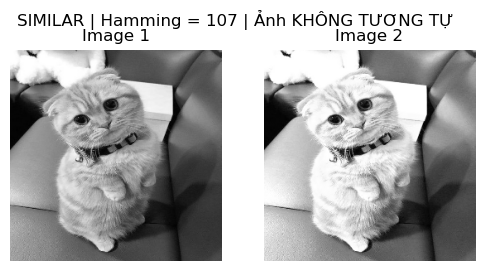

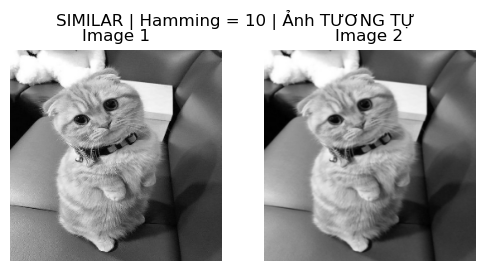

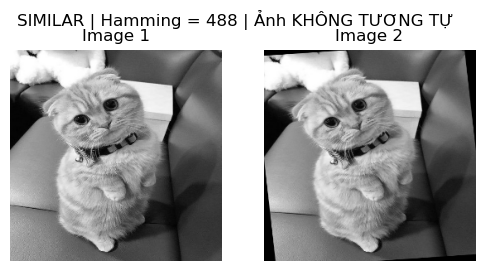

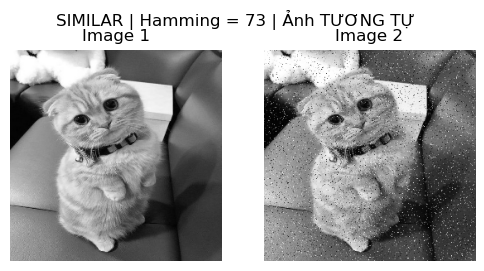

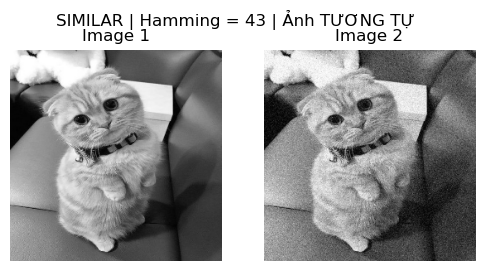

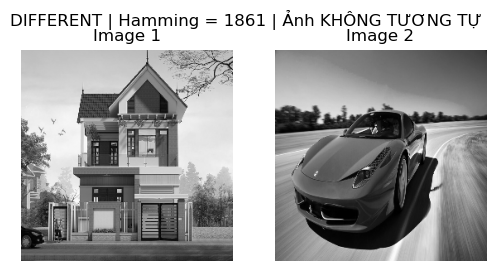

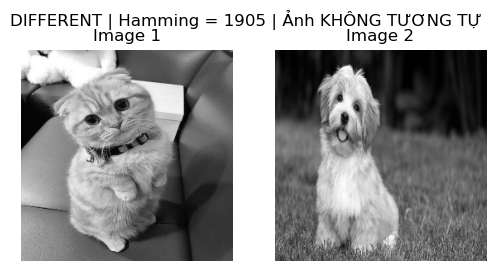

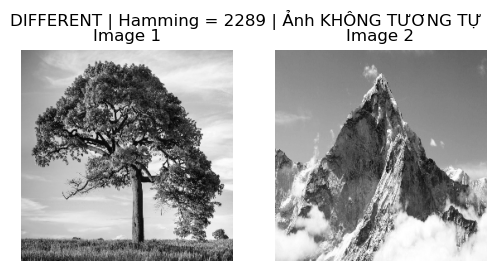

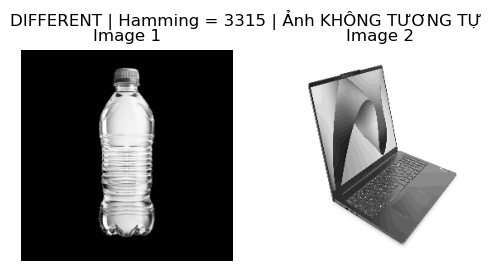

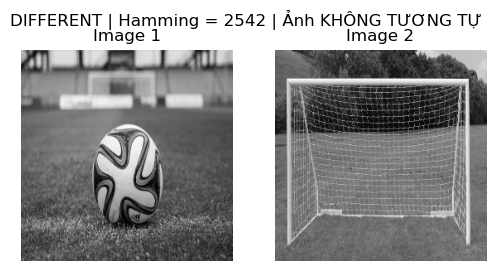

Số cặp ảnh: 10
Accuracy: 0.8
Sensitivity: 0.6
Specificity: 1.0


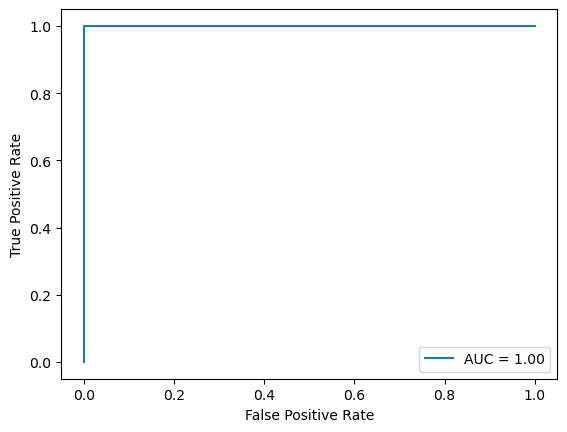

In [1]:
import cv2
import numpy as np
import pywt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import os

def load_image(path, size=(256, 256)):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, size)
    return img

def wavelet_transform(img, wavelet='haar', level=2):
    coeffs = pywt.wavedec2(img, wavelet=wavelet, level=level)
    return coeffs

def wavelet_hash(img):
    coeffs = wavelet_transform(img)
    LL = coeffs[0]  # low-frequency component
    avg = LL.mean()
    hash_bits = (LL > avg).astype(int)
    return hash_bits.flatten()

def hamming_distance(hash1, hash2):
    return np.sum(hash1 != hash2)

THRESHOLD = 100

dataset_path = "dataset"

for category in ["similar", "different"]:
    folder_path = os.path.join(dataset_path, category)

    for pair in os.listdir(folder_path):
        pair_path = os.path.join(folder_path, pair)
        images = os.listdir(pair_path)

        if len(images) < 2:
            continue

        img1_path = os.path.join(pair_path, images[0])
        img2_path = os.path.join(pair_path, images[1])

        # Load ảnh
        img1 = load_image(img1_path)
        img2 = load_image(img2_path)

        # Hash & distance
        h1 = wavelet_hash(img1)
        h2 = wavelet_hash(img2)
        dist = hamming_distance(h1, h2)

        # Kết luận
        result = "Ảnh TƯƠNG TỰ" if dist < THRESHOLD else "Ảnh KHÔNG TƯƠNG TỰ"

        # Hiển thị ảnh
        plt.figure(figsize=(6, 3))
        plt.subplot(1, 2, 1)
        plt.imshow(img1, cmap='gray')
        plt.title("Image 1")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(img2, cmap='gray')
        plt.title("Image 2")
        plt.axis("off")

        plt.suptitle(f"{category.upper()} | Hamming = {dist} | {result}")
        plt.show()

y_true = []   # 1: similar, 0: different
y_pred = []

def load_pairs(dataset_path):
    pairs = []

    # Cặp tương tự
    similar_path = os.path.join(dataset_path, "similar")
    for pair in os.listdir(similar_path):
        folder = os.path.join(similar_path, pair)
        imgs = os.listdir(folder)
        if len(imgs) >= 2:
            pairs.append((
                os.path.join(folder, imgs[0]),
                os.path.join(folder, imgs[1]),
                1
            ))

    # Cặp không tương tự
    diff_path = os.path.join(dataset_path, "different")
    for pair in os.listdir(diff_path):
        folder = os.path.join(diff_path, pair)
        imgs = os.listdir(folder)
        if len(imgs) >= 2:
            pairs.append((
                os.path.join(folder, imgs[0]),
                os.path.join(folder, imgs[1]),
                0
            ))

    return pairs

pairs = load_pairs("dataset")
print("Số cặp ảnh:", len(pairs))

for (imgA, imgB, label) in pairs:
    h1 = wavelet_hash(load_image(imgA))
    h2 = wavelet_hash(load_image(imgB))
    d = hamming_distance(h1, h2)
    
    y_true.append(label)
    y_pred.append(1 if d < THRESHOLD else 0)

acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

TN, FP, FN, TP = cm.ravel()
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print("Accuracy:", acc)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

scores = []  # dùng -distance làm score

for (imgA, imgB, label) in pairs:
    h1 = wavelet_hash(load_image(imgA))
    h2 = wavelet_hash(load_image(imgB))
    d = hamming_distance(h1, h2)
    
    scores.append(-d)

fpr, tpr, _ = roc_curve(y_true, scores)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label="AUC = %.2f" % roc_auc)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()